<a href="https://colab.research.google.com/github/antonio-decaro/Target-Set-Selection-Experimentations/blob/main/Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inizializzazione

Importiamo tutte le librerie.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import heapdict
import random
import time
import re

Inizializziamo il grafo sulla base di un dataset.

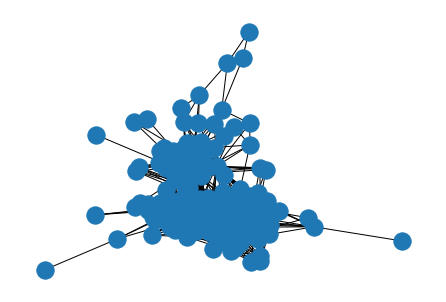

In [2]:
g = nx.Graph()

with open('jazz.txt') as f:
  lines = f.readlines()
def parse(line):
  return tuple(line.strip().split())


g.add_edges_from(list(map(parse, lines[:len(lines)])))
nx.draw(g)

# Implementazione di WTSS

Vogliamo implementare l'algoritmo pesato di Target Set Selection

In [3]:
def argmax(G, t, c):
  def ratio(v):
    d = G.degree(v)
    if d == 0:
      return float('-inf')
    return t[v]/(d * (d+1))

  v = max(G.nodes(), key=lambda x: ratio(x))
  max_ratio = ratio(v)
  max_ratio_nodes = set()
  for v in G.nodes():
    if ratio(v) == max_ratio:
      max_ratio_nodes.add(v)

  v = max(max_ratio_nodes, key=lambda x: c[x])
  return v


def decrease_thresholds(G, v, t):
  for u in G.neighbors(v):
    t[u] -= 1

def clean_graph(G):
  to_remove = set()
  for node in G.nodes():
    if G.degree(node) == 0:
      to_remove.add(node)
  for node in to_remove:
    G.remove_node(node)

In [4]:
def WTSS(graph, thresholds, costs):
  G = graph.copy()
  t = thresholds.copy()
  S = set()

  while G.number_of_nodes():
    # controlliamo se abbiamo nodi con threshold uguale a 0, e rimuoviamoli dal grafo
    for v in G.nodes():
      if t[v] == 0:
        decrease_thresholds(G, v, t)
        break
    else:
      available_nodes = set()
      # aggiungi alla lista dei nodi disponibili tutti quelli che hanno grado inferiore del threhsold
      for node in G.nodes():
        if G.degree(node) < t[node]:
          available_nodes.add(node)
      # se esistono tali nodi, aggiungiamo ad S quello con il costo inferiore
      if available_nodes:
        v = min(available_nodes, key=lambda x: costs[x])
        S.add(v)
        decrease_thresholds(G, v, t)
      # altrimenti rimuoviamo dal grafo il nodo con ratio maggiore (e con costo maggiore)
      else: 
        v = argmax(G, t, costs)

    G.remove_node(v)
    # clean_graph(G)
  return S

## Experimentations
Vogliamo sperimentare il comportamento dell'algoritmo implementato.
Definiamo prima il vettore dei costi `c=[c1,...,cn]`.

In [ ]:
c = {n: random.randint(2, 5) for n in g.nodes()}

### Threshold costante

Vogliamo verificare il comportamento del nostro algritmo con un threshold costante, nel nostro caso uguale a 2.

In [66]:
t = {n: 2 for n in g.nodes()}

sol = WTSS(g, t, c)

print(f'Target Set Size: {len(sol)}')

Target Set Size: 7


### Threshold a Maggioranza

Bisogna capire che intende la prof

### Threshold proporzionale al grado

Il threshold è definito in maniera proporzionale al grado del nodo. Si utilizza una costante lambda per modificare il valore del threshold.

Per un nodo *v*: *t(v) = LAMBDA * d(v)*.

In [83]:
LAMBDA = 0.2

t = {n: int(g.degree(n) * LAMBDA) for n in g.nodes()}

sol = WTSS(g, t, c)

print(f'Target Set Size: {len(sol)}')

Target Set Size: 5


### Modello non deterministico
A questo punto cosa succede se invece di utilizzare dei threshold decidessimo di assegnare una probabilità ad ogni arco?
Utilizziamo il __processo di decisione differita__ e calcoliamo il valore medio di diverse iterazioni.

Definiamo inoltre una funzione `check_coeverage` per controllare che venga raggiunto il **Complete Cascade**.

In [62]:
from typing import Collection
def differ_decision(graph: nx.Graph, prob) -> nx.Graph:
  dd = graph.copy()

  if type(prob) in (int, float):
    prob = {e: prob for e in graph.edges()}
  else:
    if len(prob) != graph.number_of_edges():
      raise AttributeError('probability list has different size then number of edges')

  for e in graph.edges():
    if random.randint(0, 100) > prob[e]:
      dd.remove_edge(*e)
  return dd

def check_coverage(g, sol):
  explored = set()
  def dfs(v):
    if v not in explored:
      explored.add(v)
    for u in dd.neighbors(v):
      if u not in explored:
        dfs(u)

  for node in sol:
    dfs(node)

  return len(explored) == g.number_of_nodes()

Utilizziamo per ogni arco una probabilità di attivazione costante. Nel nostro caso 20%.

In [65]:
import math

PROB = 50 # probabilità che un arco venga attivato
ITERATIONS = 10

tot_size = 0
correct = True
for i in range(ITERATIONS):
  dd = differ_decision(g, PROB)
  sol = WTSS(dd, {n: 1 for n in g.nodes()}, c)
  tot_size += len(sol)
  if not check_coverage(dd, sol):
    print('Errore! Complete Cascade non raggiunto')
    correct = False
    break

if correct:
  print(f"Target Set size [prob={PROB}%]: {math.ceil(tot_size / ITERATIONS)}")

Target Set size [prob=50%]: 7
